### Car Damage Object Detection with YOLOv11

 This project focuses on detecting car damages using two variants of YOLOv11:
   - YOLOv11 Large
   - YOLOv11 Medium

 We also compare the results with and without data augmentation.
 The augmentation techniques include:
   - flipping
   - random brightness
   - random rotation (±15 degrees)
    - histogram equalization
The following script loads multiple experiment folders (e.g., YOLOv11 Large with augmentation,
YOLOv11 Large without augmentation, YOLOv11 Medium with augmentation, YOLOv11 Medium without augmentation, etc.),
extracts and plots metrics such as training loss, recall, precision, and mAP@0.5. 
Each plot will let us compare how these models and augmentation choices perform over epochs.


In [64]:
from ultralytics import YOLO
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display,Image
experiment_folders = [
    r"C:\Slynder_Task\notebooks\many_types_dataset\runs\detect\b8_large_p=0.1",
    r'C:\Slynder_Task\notebooks\many_types_dataset\runs\detect\b8_medium_p=0.1',
    r"C:\Slynder_Task\notebooks\many_types_dataset\runs\detect\no_aug_b8_large_p=0.1",
    r"C:\Slynder_Task\notebooks\many_types_dataset\runs\detect\no_aug_b8_medium_p=0.1"
]
results_filename = 'results.csv'

In [48]:
df_dict = {}

for folder in experiment_folders:
    exp_name = os.path.basename(folder)  
    csv_path = os.path.join(folder, results_filename)
    
    if not os.path.isfile(csv_path):
        print(f"Warning: {csv_path} not found. Skipping folder '{folder}'.")
        continue
    
 
    df = pd.read_csv(csv_path)
    
    # Compute total training loss: box + cls + dfl
    if all(col in df.columns for col in ["train/box_loss", "train/cls_loss", "train/dfl_loss"]):
        df["train/total_loss"] = (
            df["train/box_loss"] + df["train/cls_loss"] + df["train/dfl_loss"]
        )
    else:
        print(f"Warning: Could not compute total_loss in {exp_name}. Columns missing.")
    
    df_dict[exp_name] = df

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metric(metric_key, title, ylabel, smoothing_window=5, max_epoch=200):
    """
    Plots a given metric (e.g., 'train/total_loss', 'metrics/precision(B)') across experiments,
    smoothing the plot via a rolling average and stopping at a specified epoch (default=200).

    Args:
        metric_key (str): Name of the column in the DataFrame to plot.
        title (str): Plot title.
        ylabel (str): Y-axis label.
        smoothing_window (int, optional): Window size for rolling average. Defaults to 5.
        max_epoch (int, optional): The last epoch to include in the plot. Defaults to 200.
    """
    plt.figure(figsize=(8, 6))
    for exp_name, df in df_dict.items():
        # Ensure the metric exists in the current DataFrame
        if metric_key not in df.columns:
            print(f"Warning: '{metric_key}' not found in {exp_name}. Skipping.")
            continue
        
        # Filter DataFrame to only epochs <= max_epoch
        df_filtered = df[df["epoch"] <= max_epoch].copy()
        
        # Apply rolling average to smooth the curve
        # The 'center=False' means the average is computed using the current row and the previous rows
        df_filtered[f"{metric_key}_smoothed"] = (
            df_filtered[metric_key].rolling(window=smoothing_window, center=False).mean()
        )
        
        # Plot the smoothed values
        plt.plot(
            df_filtered["epoch"], 
            df_filtered[f"{metric_key}_smoothed"], 
            label=exp_name
        )
    
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



### Training Loss Plot
We compare how the training loss evolves over epochs for YOLOv11 Large vs Medium,
with and without augmentation. Lower loss typically suggests better training performance.

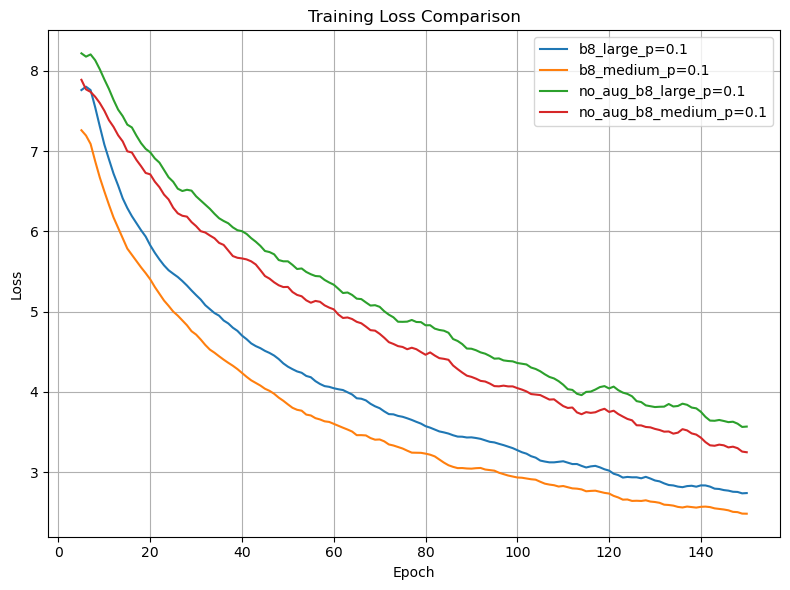

In [50]:
plot_metric(
    metric_key="train/total_loss",  
    title="Training Loss Comparison",
    ylabel="Loss",
    smoothing_window=5,            
    max_epoch=150                  
)

 ### Precision Plot
 Precision measures how many predicted damages are actually correct.
 High precision means fewer false positives. We compare YOLOv11 Large vs Medium,
 with and without augmentation, to see if augmentation helps reduce misdetections

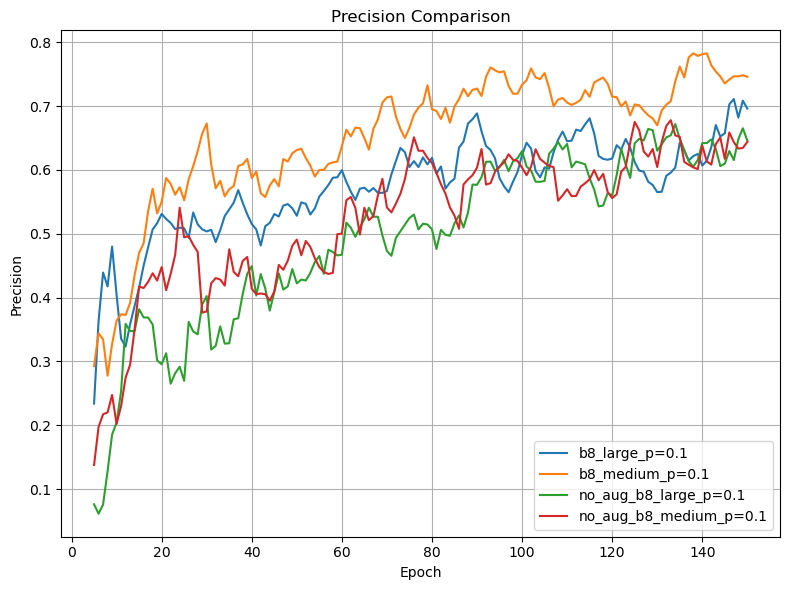

In [56]:
plot_metric(
    metric_key="metrics/precision(B)",
    title="Precision Comparison",
    ylabel="Precision",
    smoothing_window=5,
    max_epoch=150
)


 ### mAP@0.5 Plot
 Mean Average Precision at IoU threshold 0.5 is a common metric in object detection.
 It summarizes both precision and recall. We see here if using augmentation (flipping,
 random brightness, random rotate ±15, equalization) helps improve detection.

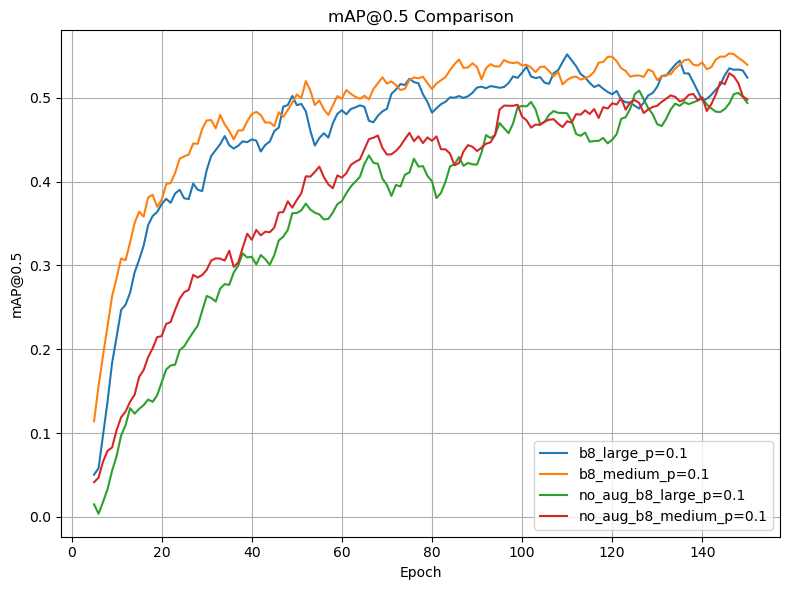

In [55]:
plot_metric(
    metric_key="metrics/mAP50(B)",
    title="mAP@0.5 Comparison",
    ylabel="mAP@0.5",
    smoothing_window=5,
    max_epoch=150
)

### Recall Plot
 Recall indicates how many actual damage instances were correctly identified by the model.
 High recall means the model misses fewer damaged areas. Here we compare YOLOv11 Large vs Medium,
 with and without augmentation, to see if augmentation techniques help recall.

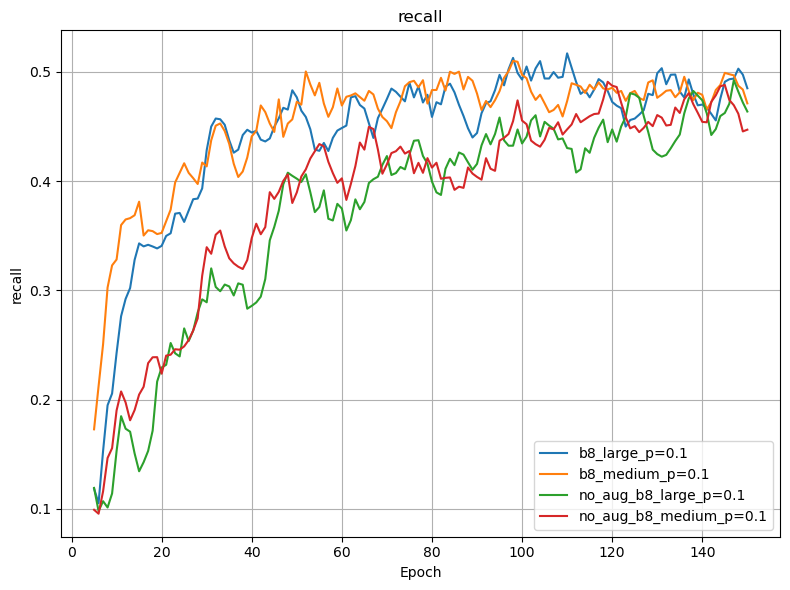

In [53]:
plot_metric(
    metric_key="metrics/recall(B)",
    title="recall",
    ylabel="recall",
    smoothing_window=5,
    max_epoch=150
)

From these plots and metrics, we can draw a few clear takeaways:

Augmentation Helps
Both the Large and Medium models that used augmentation (b8_large_p=0.1 and b8_medium_p=0.1) consistently outperform their no-augmentation counterparts in terms of training loss, precision, recall, and mAP@0.5. This confirms that flips, brightness changes, rotations, and equalization help the model generalize better.

Medium Model Edges Out Large
Among the augmented models, the Medium variant (b8_medium_p=0.1) shows slightly better final performance—lower training loss and higher precision, recall, and mAP—compared to the Large variant. This could be because the Medium model is easier to optimize or less prone to overfitting than the Large model under these particular training conditions.

No-Aug Models Underperform
The no-augmentation variants lag behind in every metric. This gap illustrates how critical augmentation can be for detecting damages under diverse real-world conditions (lighting changes, different angles, etc.).

Overall, the YOLOv11 Medium model with augmentation (b8_medium_p=0.1) appears to strike the best balance of convergence and final accuracy in car damage detection, followed closely by YOLOv11 Large with augmentation (b8_large_p=0.1).

# yolo11 medium with augmentation model confusion matrix:

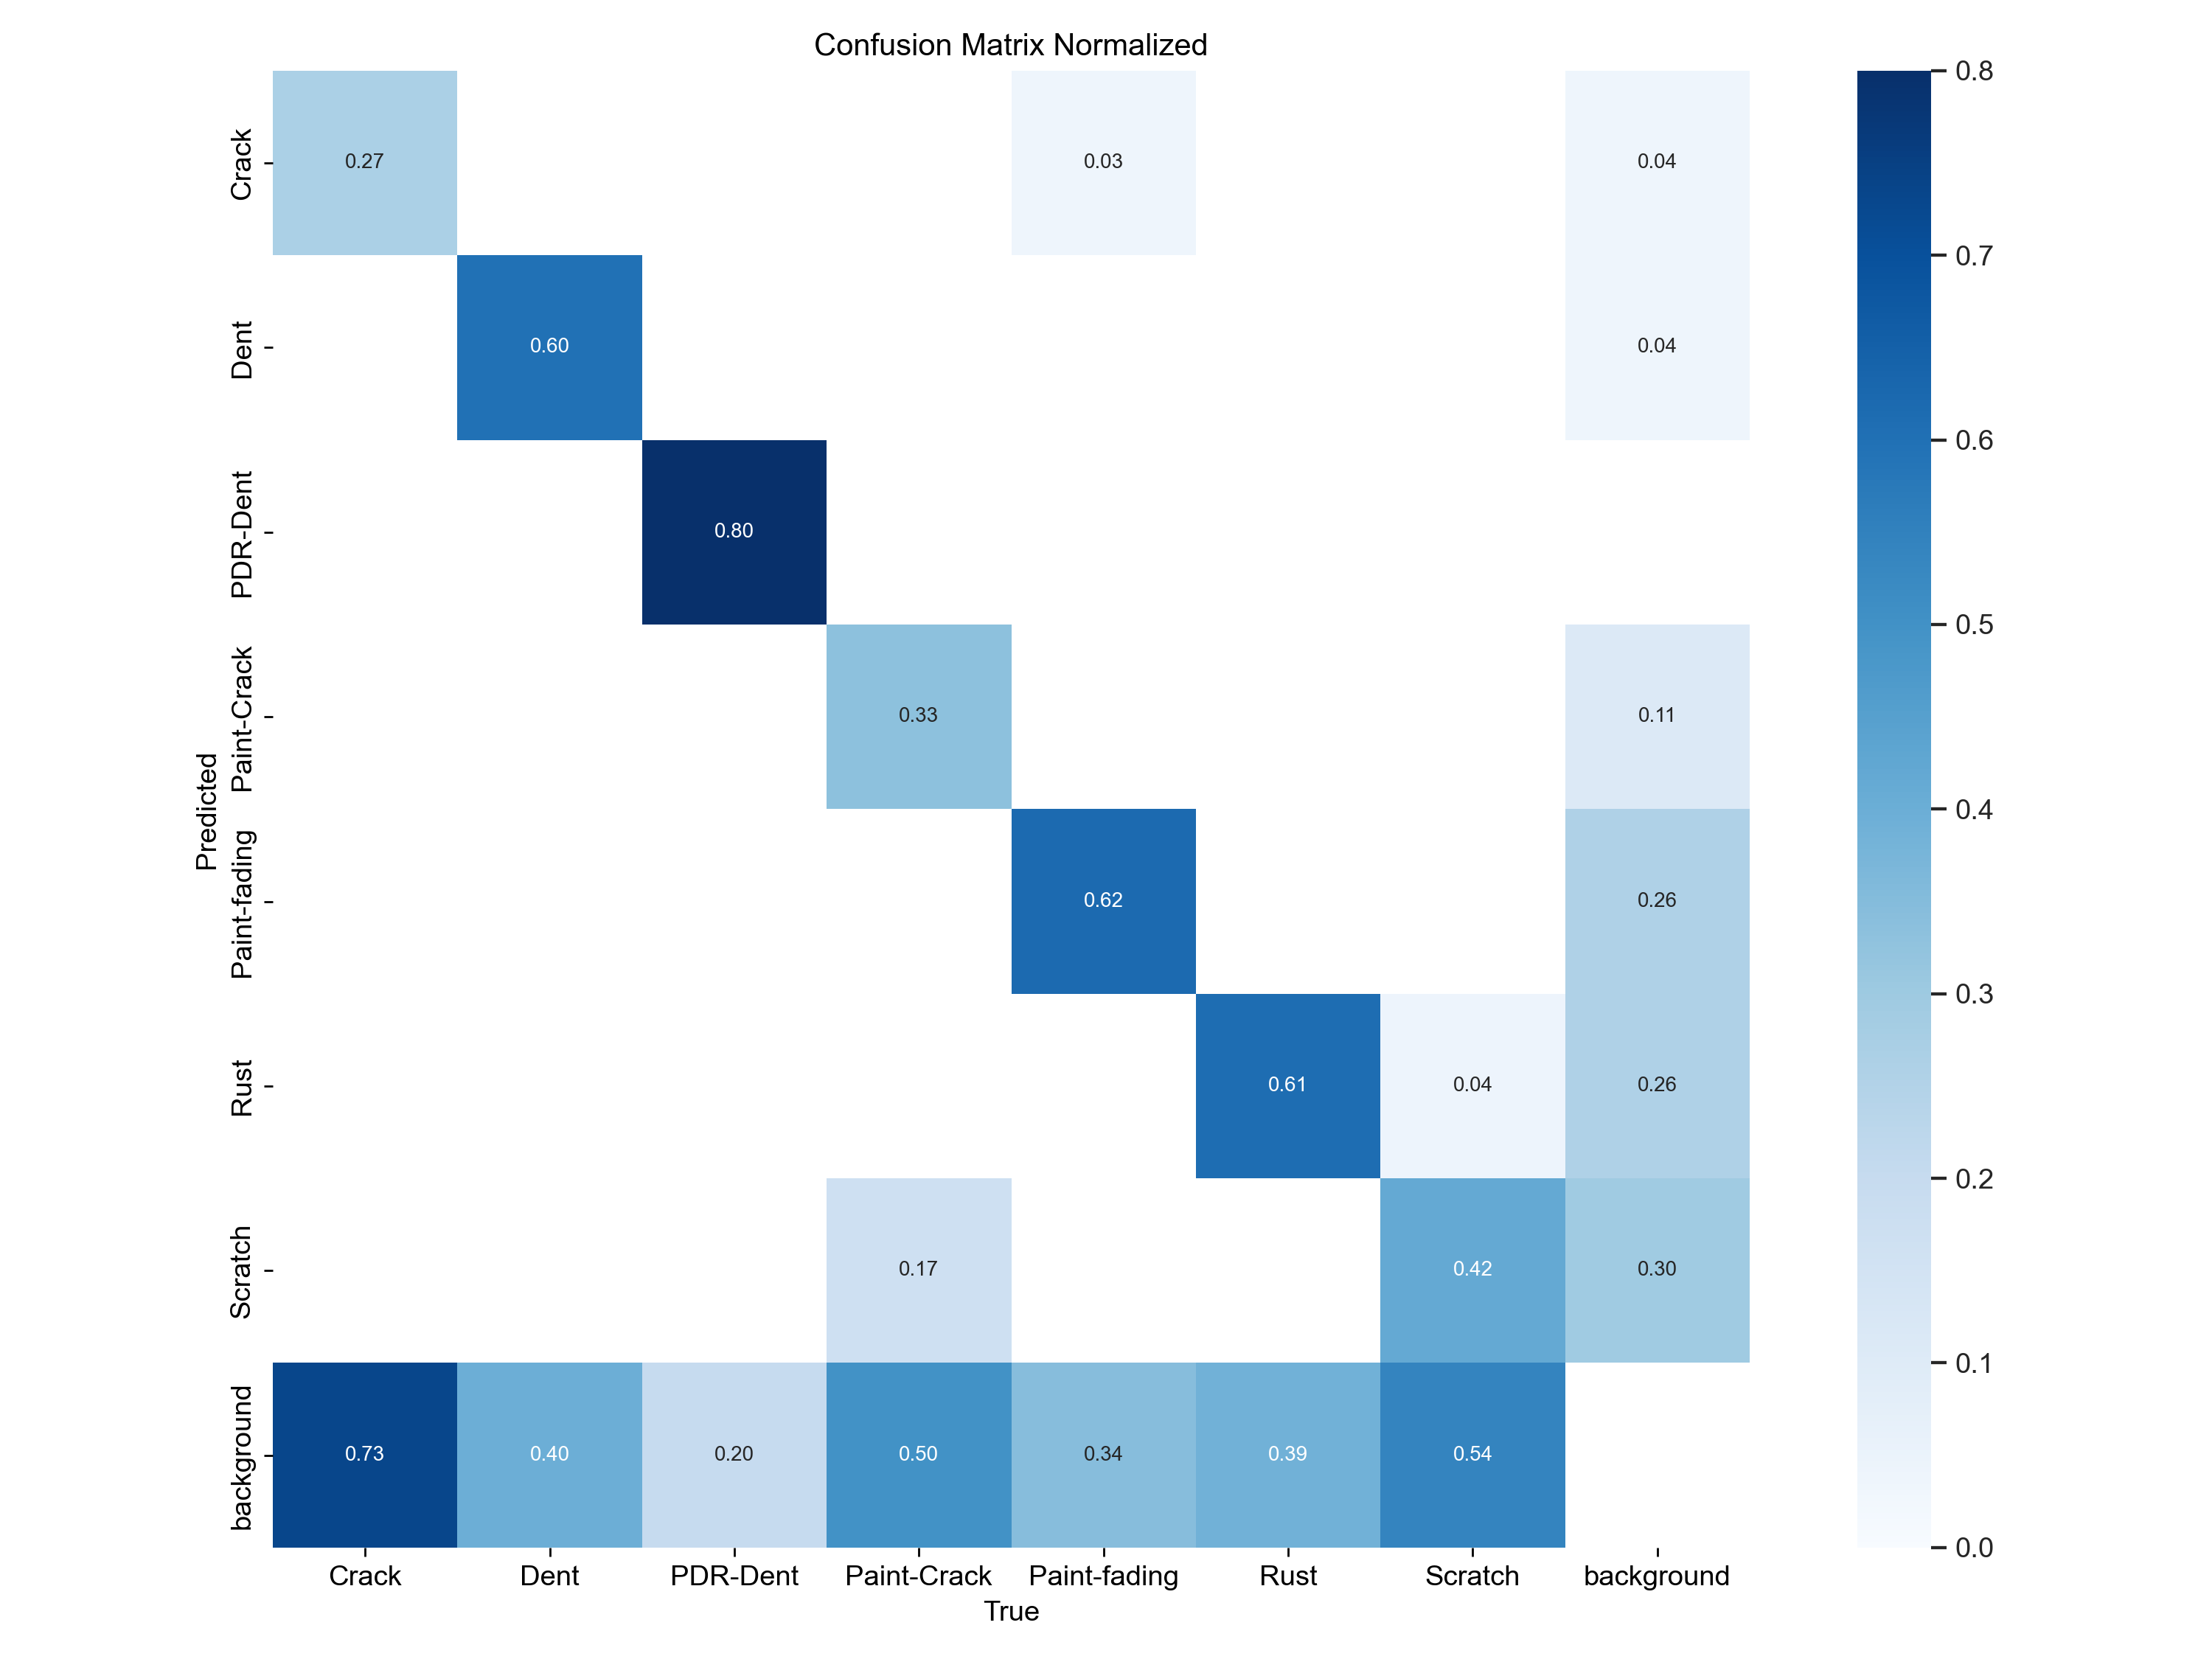

In [66]:
display(Image(filename=r'C:\Slynder_Task\notebooks\many_types_dataset\runs\detect\b8_medium_p=0.1\confusion_matrix_normalized.png'))

# sample validation batch for the same model 

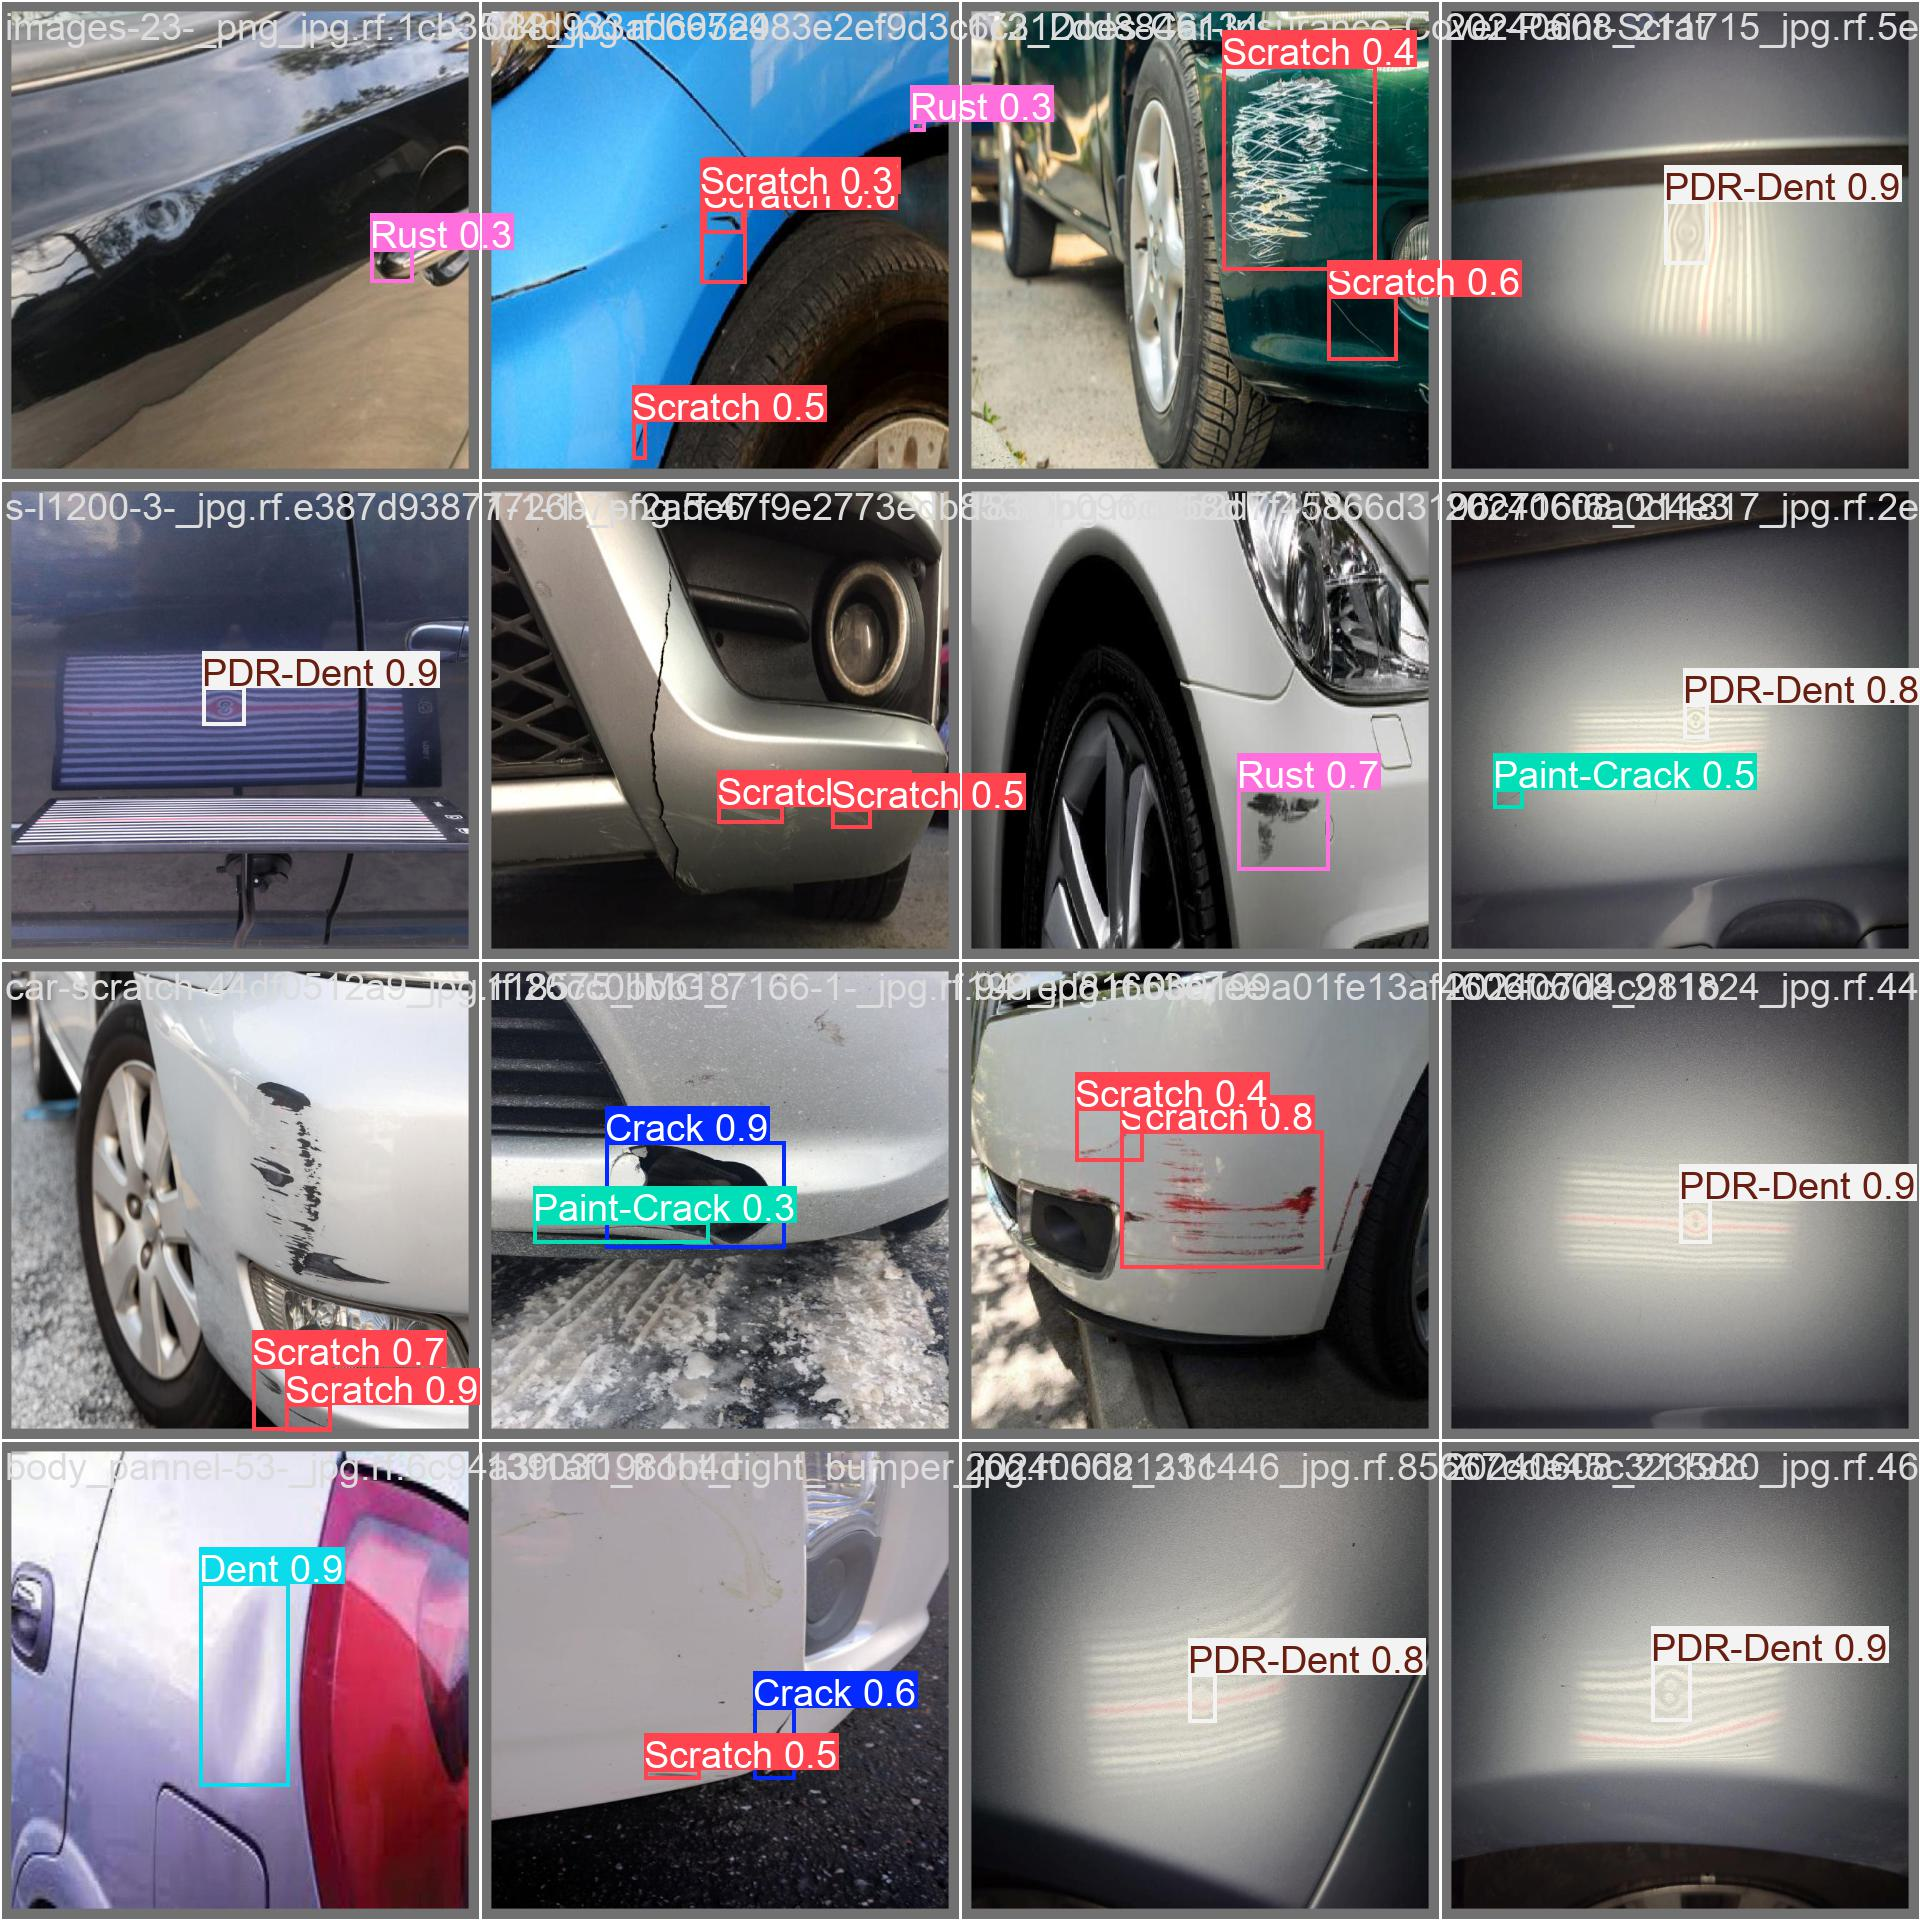

In [67]:
display(Image(filename=r'C:\Slynder_Task\notebooks\many_types_dataset\runs\detect\b8_medium_p=0.1\val_batch2_pred.jpg'))

# Post processing using NMS to suppress redundant detections 

With NMS:


0: 640x640 1 Paint-fading, 8 Rusts, 87.1ms
Speed: 3.0ms preprocess, 87.1ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


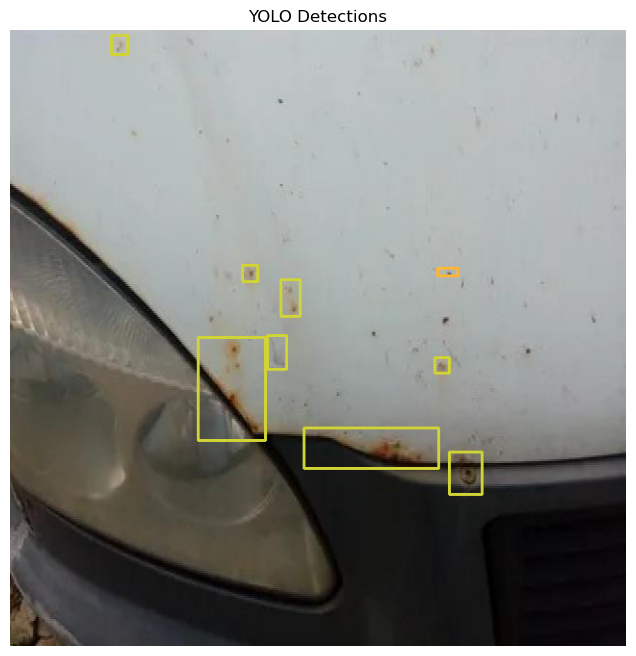

In [81]:
import cv2
import supervision as sv
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Load the image
image_path = r"C:\Slynder_Task\Car_paint_damage_detection.v10-car-damage-dataset.yolov11\test\images\i-30-_30_11zon_jpg.rf.a3d1dce0c741e8a57d1e17863ccc153b.jpg"
image = cv2.imread(image_path)

# Load the YOLO model
model = YOLO(r'C:\Slynder_Task\notebooks\many_types_dataset\runs\detect\b8_medium_p=0.1\weights\best.pt')

# Perform inference
result = model(image)[0]

# Convert results to detections
detections = sv.Detections.from_ultralytics(result).with_nmm()

# Annotate detections directly on the image
annotator = sv.BoxAnnotator()  # Supervision's box annotator
annotated_image = annotator.annotate(scene=image.copy(), detections=detections)

# Show the annotated image in the notebook
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct colors
plt.axis("off")
plt.title("YOLO Detections")
plt.show()
